# Problem Description and Data Description

The objective of this Kaggle competition is to develop an algorithm capable of detecting metastatic cancer in small image patches extracted from larger digital pathology scans. The specific task is to classify each image patch as either containing metastatic tissue or not.

The dataset includes a large collection of these small pathology images, each labeled to indicate the presence or absence of metastatic tissue. The data is split into a training set, used to build and tune the model, and a test set, used for evaluating its performance.









**Training Data:**

The training set consists of 220,025 RGB images, each sized 96x96 pixels. Corresponding labels are provided in the train_labels.csv file, where a label of 1 indicates the presence of metastatic tissue and 0 indicates its absence.

**Test Data:**

The test set includes 57,458 RGB images, also sized 96x96 pixels. The goal is to predict binary labels for these images, identifying whether each contains metastatic tissue.

**Evaluation Metric:**

The competition is evaluated using the Area Under the ROC Curve (AUC). This metric assesses how well the model distinguishes between the two classes—metastatic and non-metastatic tissue—based on its predicted probabilities.

# Load Libraries and Data

In [ ]:
# Load libraries for project
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import time
import pandas as pd
import cv2
from PIL import Image
import sys
import os

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving kaggle.json to kaggle.json


In [ ]:
!pwd

/content


In [ ]:
!pip install -q kaggle


In [ ]:
import os
os.environ['KAGGLE_CONFIG_DIR'] = "/content"
"chmod 600 /content/kaggle.json"

'chmod 600 /content/kaggle.json'

In [ ]:
!kaggle competitions download -c histopathologic-cancer-detection

 99% 6.26G/6.31G [00:21<00:00, 375MB/s]
100% 6.31G/6.31G [00:21<00:00, 315MB/s]


In [ ]:
os.listdir("./")

['.config',
 'drive',
 'kaggle.json',
 'histopathologic-cancer-detection.zip',
 'sample_data']

In [ ]:
!unzip -q histopathologic-cancer-detection.zip -d histopathologic-cancer-detection

In [ ]:
os.listdir("./histopathologic-cancer-detection")

['sample_submission.csv', 'test', 'train', 'train_labels.csv']

In [ ]:
from skimage.io import imread
from skimage.transform import resize
import matplotlib.pyplot as plt



In [ ]:
train_dir = "histopathologic-cancer-detection/train/"
test_dir = "histopathologic-cancer-detection/test/"

train_labels = pd.read_csv('histopathologic-cancer-detection/train_labels.csv')
train_labels.head(10)

,id,label
0,f38a6374c348f90b587e046aac6079959adf3835,0
1,c18f2d887b7ae4f6742ee445113fa1aef383ed77,1
2,755db6279dae599ebb4d39a9123cce439965282d,0
3,bc3f0c64fb968ff4a8bd33af6971ecae77c75e08,0
4,068aba587a4950175d04c680d38943fd488d6a9d,0
5,acfe80838488fae3c89bd21ade75be5c34e66be7,0
6,a24ce148f6ffa7ef8eefb4efb12ebffe8dd700da,1
7,7f6ccae485af121e0b6ee733022e226ee6b0c65f,1
8,559e55a64c9ba828f700e948f6886f4cea919261,0
9,8eaaa7a400aa79d36c2440a4aa101cc14256cda4,0


# Exploratory Data Analysis (EDA)

In [ ]:
#train_labels['label'] = train_labels['label'].astype(str)
train_labels['id'] = train_labels['id'] + '.tif'
print(train_labels.shape)
train_labels.head()

(220025, 2)


,id,label
0,f38a6374c348f90b587e046aac6079959adf3835.tif,0
1,c18f2d887b7ae4f6742ee445113fa1aef383ed77.tif,1
2,755db6279dae599ebb4d39a9123cce439965282d.tif,0
3,bc3f0c64fb968ff4a8bd33af6971ecae77c75e08.tif,0
4,068aba587a4950175d04c680d38943fd488d6a9d.tif,0


**Show some random images with their labels**

6955
217460
101515
26193
181788
205104
33022
163088
94920
100107


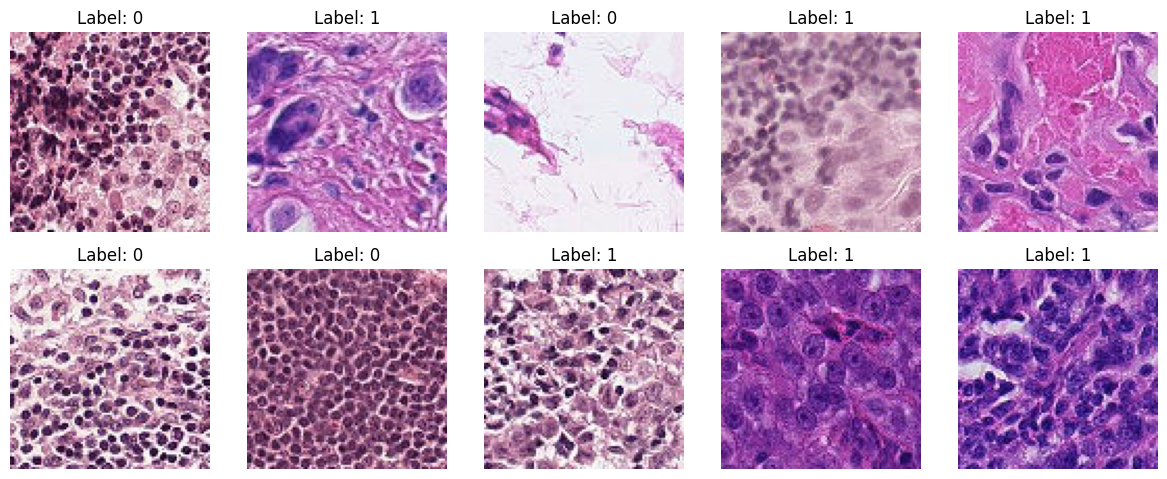

In [ ]:
import random
n_images = 10
plt.figure(figsize=(12, 12))

for i in range(n_images):
    plt.subplot(5, 5, i+1)
    idx = random.randint(0, len(train_labels) - 1)  # Pick a random index
    print(idx)
    image_path = os.path.join(train_dir, train_labels["id"][idx])
    #img = plt.imread('/content/drive/MyDrive/5511_cnn/data/train/419337871307507472276372086416eb49e5fefc.tif')
    img = plt.imread(image_path)
    plt.imshow(img)
    plt.title(f"Label: {train_labels['label'][idx]}")
    plt.axis('off')  # Hide the axis

plt.tight_layout()
plt.show()

In [ ]:
# Basic statistics
print(f"Total Training images: {len(train_labels)}")
print(f"Positive examples: {np.sum(train_labels['label'] == 1)}")
print(f"Negative examples: {np.sum(train_labels['label'] == 0)}")

Total Training images: 220025
Positive examples: 89117
Negative examples: 130908


In [ ]:
train_labels.isnull().sum()

,0
id,0
label,0


**We have no missing data, so no data imputation is required**

**Let us check distribution of label values**

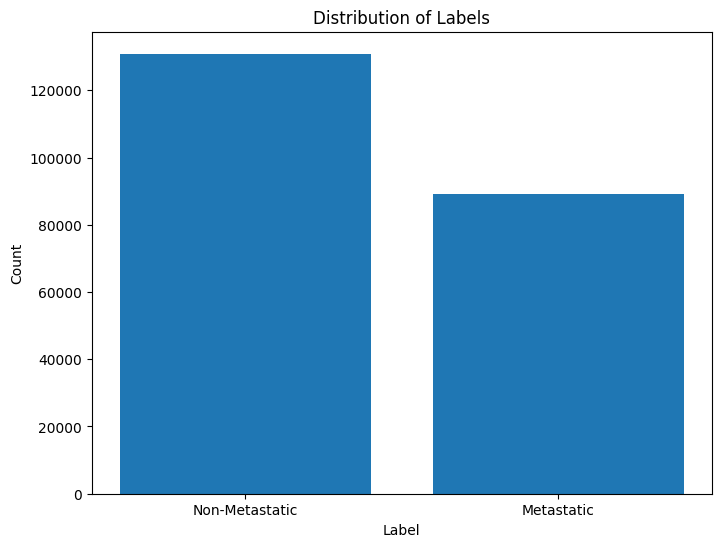

Label 0: 130908 samples (59.50%)
Label 1: 89117 samples (40.50%)


In [ ]:
# Count the number of samples for each label
label_counts = train_labels['label'].value_counts()

# Create a bar plot
plt.figure(figsize=(8, 6))
plt.bar(label_counts.index, label_counts.values)
plt.xlabel('Label')
plt.ylabel('Count')
plt.title('Distribution of Labels')
plt.xticks([0, 1], ['Non-Metastatic', 'Metastatic'])
plt.show()

# Print the count and percentage of each label
total_samples = len(train_labels)
for label, count in label_counts.items():
    percentage = (count / total_samples) * 100
    print(f"Label {label}: {count} samples ({percentage:.2f}%)")

# Model Building

**Architecture and Reasoning**


For the Histopathologic Cancer Detection task, selecting the right model architecture is critical due to the complex patterns and high variability present in histopathologic images. Accurately identifying metastatic tissue requires a model capable of capturing fine-grained visual features.

Convolutional Neural Networks (CNNs) are particularly well-suited for this type of image classification problem. Their ability to automatically learn spatial hierarchies of features makes them highly effective in processing medical images. Additionally, transfer learning using pre-trained models can be explored to leverage learned representations from large image datasets.

For the CNN approach, we would start with an input layer, followed by multiple convolutional layers to extract features, and dense layers for classification. To improve generalization and reduce overfitting, we can also include dropout layers and batch normalization.

We will experiment with various hyperparameters, such as the number of layers, learning rate, and dropout rates, to optimize performance and achieve robust results.


**Imports and Helper Functions**

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D
from tensorflow.keras.layers import Dropout, Flatten, Dense, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import VGG16, ResNet50, InceptionV3
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split

In [ ]:
train_labels['label'] = train_labels['label'].astype(str)
train_df, val_df = train_test_split(train_labels, test_size=0.2)

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Define image data augmentation
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest')

datagen = ImageDataGenerator(rescale=1./255)  # Rescaling

train_generator = datagen.flow_from_dataframe(
    dataframe=train_df,
    directory=train_dir,
    x_col='id',
    y_col='label',
    target_size=(96, 96),
    batch_size=32,
    class_mode='binary')

validation_generator = datagen.flow_from_dataframe(
    dataframe=val_df,
    directory=train_dir,
    x_col='id',
    y_col='label',
    target_size=(96, 96),
    batch_size=32,
    class_mode='binary')

Found 176020 validated image filenames belonging to 2 classes.
Found 44005 validated image filenames belonging to 2 classes.


In [ ]:
def show_model_accuracy(history):
    plt.plot(history.history['auc'])
    plt.plot(history.history['val_auc'])
    plt.title('Train/Validate Accuracy over time')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'validate'], loc='upper left')
    plt.show();

In [ ]:
callback = tf.keras.callbacks.EarlyStopping(monitor='val_binary_accuracy', patience=5, restore_best_weights=True)

In [ ]:
df_results = pd.DataFrame(columns=['Model Name', 'AUC', 'Val AUC', 'Kaggle Private Score', 'Kaggle Public Score'])
df_results = pd.DataFrame(columns=['Model Name', 'Kaggle Private Score', 'Kaggle Public Score'])


In [ ]:
def add_to_results(model_name,history, kaggle_private_score, kaggle_public_score):
    global df_results  # Declare df_results as global to modify the global instance

    # Create a dictionary for the new row
    new_row = {
        'Model Name': model_name,
        #'AUC': history.history['auc'][-1],  # Assuming you want the last epoch's value
        #'Val AUC': history.history['val_auc'][-1],  # Assuming you want the last epoch's value
        'Kaggle Private Score': kaggle_private_score,
        'Kaggle Public Score': kaggle_public_score
    }

    # Create a DataFrame from the new row
    new_rows_df = pd.DataFrame([new_row])  # Create a DataFrame directly from the dictionary

    # Append the new DataFrame to the existing df_results
    df_results = pd.concat([df_results, new_rows_df], ignore_index=True)


# Models and Results

## Test and Save Methods

In [ ]:
# retrieve list of file
file_list = os.listdir(test_dir)

# generate empty dataframe
test_df = pd.DataFrame({'id':file_list})
test_df.head()

,id
0,d751307df11d902f28fab571d7aa8cf889148d5e.tif
1,62ee78062e98a8041451d507f9b39cf706a797c6.tif
2,a4a6a63dd84bc88ba13dde3223e9e281f1b29254.tif
3,0c4ed321a19bf5cbd1c4ae48d6d0b7b000492b08.tif
4,93b6fd30b8afc3a9ad976b480ece7150eaddc1f7.tif


In [ ]:
# image generator for the test set
test_generator = ImageDataGenerator(rescale=1./255.).flow_from_dataframe(
    dataframe=test_df,
    directory=test_dir,
    x_col='id',
    y_col=None,
    target_size=(96,96),
    batch_size=1,
    shuffle=False,
    class_mode=None)

Found 57458 validated image filenames.


In [ ]:

def save_submission(model, submission_filename):
    # generate empty dataframe
    test_df = pd.DataFrame({'id':file_list})
    # remove the file extension in the id column
    test_df['id'] = test_df['id'].apply(lambda x: x.split('.')[0])

    predictions = model.predict(test_generator, verbose=1)
    # let's rearrange the predictions
    predictions = np.transpose(predictions)[0]
    # fill the prediction in the label column
    test_df['label'] = list(map(lambda x: 0 if x < 0.5 else 1, predictions))

    test_df.to_csv(submission_filename, index=False)
    files.download(submission_filename)

## Try Various Models and Hyperparameters

**Model 1**

Start with some default CNN model with required layers defined in architecture earlier

In [ ]:
model1 = Sequential([
    Conv2D(32, (3,3), activation='relu', input_shape=(96, 96, 3)),
    MaxPooling2D(2,2),

    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D(2,2),

    Conv2D(128, (3,3), activation='relu'),
    MaxPooling2D(2,2),

    Flatten(),
    Dense(512, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

model1.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=[tf.keras.metrics.AUC(name='auc'), tf.keras.metrics.BinaryAccuracy()])


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:

history1 = model1.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=20,
    callbacks = [callback]
)


Epoch 1/20


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


5501/5501 ━━━━━━━━━━━━━━━━━━━━ 144s 25ms/step - auc: 0.8418 - binary_accuracy: 0.7778 - loss: 0.4754 - val_auc: 0.9193 - val_binary_accuracy: 0.8426 - val_loss: 0.3549
Epoch 2/20
5501/5501 ━━━━━━━━━━━━━━━━━━━━ 132s 24ms/step - auc: 0.9268 - binary_accuracy: 0.8575 - loss: 0.3361 - val_auc: 0.9467 - val_binary_accuracy: 0.8511 - val_loss: 0.3320
Epoch 3/20
5501/5501 ━━━━━━━━━━━━━━━━━━━━ 133s 24ms/step - auc: 0.9457 - binary_accuracy: 0.8806 - loss: 0.2902 - val_auc: 0.9444 - val_binary_accuracy: 0.8707 - val_loss: 0.3141
Epoch 4/20
5501/5501 ━━━━━━━━━━━━━━━━━━━━ 132s 24ms/step - auc: 0.9558 - binary_accuracy: 0.8939 - loss: 0.2615 - val_auc: 0.9599 - val_binary_accuracy: 0.9002 - val_loss: 0.2472
Epoch 5/20
5501/5501 ━━━━━━━━━━━━━━━━━━━━ 133s 24ms/step - auc: 0.9617 - binary_accuracy: 0.9020 - loss: 0.2434 - val_auc: 0.9630 - val_binary_accuracy: 0.9044 - val_loss: 0.2380
Epoch 6/20
5501/5501 ━━━━━━━━━━━━━━━━━━━━ 135s 25ms/step - auc: 0.9682 - binary_accuracy: 0.9117 - loss: 0.2209 - va

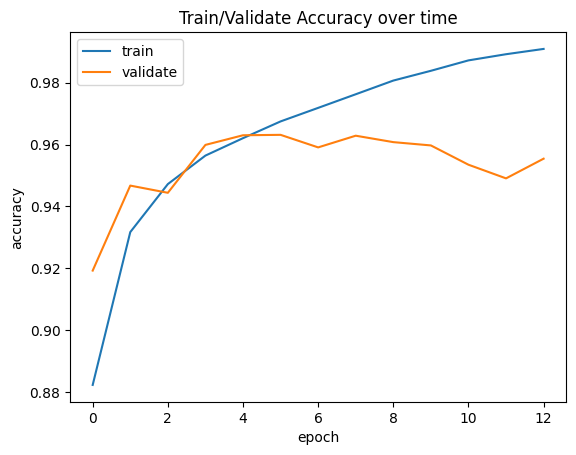

In [ ]:
show_model_accuracy(history1)

In [ ]:

save_submission(model1, 'submission1_rs_cnn.csv')


57458/57458 ━━━━━━━━━━━━━━━━━━━━ 105s 2ms/step


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

**Model 2**

Trying to use some pre-trained model as base model

In [ ]:
def create_model_with_vgg16(input_shape=(96, 96, 3)):
    base_model = VGG16(input_shape=input_shape, include_top=False, weights='imagenet')
    base_model.trainable = False  # Freeze the base model

    model = Sequential([
        base_model,
        GlobalAveragePooling2D(),
        Dense(1024, activation='relu'),
        Dropout(0.5),
        Dense(1, activation='sigmoid')
    ])

    model.compile(optimizer=Adam(learning_rate=1e-4), loss='binary_crossentropy', metrics=[tf.keras.metrics.AUC(name='auc'), tf.keras.metrics.BinaryAccuracy()])
    return model



In [ ]:
model2 = create_model_with_vgg16()
history2 = model2.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=20,
    callbacks = [callback]
)

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step
Epoch 1/20
5501/5501 ━━━━━━━━━━━━━━━━━━━━ 317s 57ms/step - auc: 0.8797 - binary_accuracy: 0.8070 - loss: 0.4188 - val_auc: 0.9228 - val_binary_accuracy: 0.8472 - val_loss: 0.3438
Epoch 2/20
5501/5501 ━━━━━━━━━━━━━━━━━━━━ 303s 55ms/step - auc: 0.9222 - binary_accuracy: 0.8495 - loss: 0.3437 - val_auc: 0.9304 - val_binary_accuracy: 0.8568 - val_loss: 0.3274
Epoch 3/20
5501/5501 ━━━━━━━━━━━━━━━━━━━━ 303s 55ms/step - auc: 0.9298 - binary_accuracy: 0.8574 - loss: 0.3272 - val_auc: 0.9346 - val_binary_accuracy: 0.8617 - val_loss: 0.3171
Epoch 4/20
5501/5501 ━━━━━━━━━━━━━━━━━━━━ 303s 55ms/step - auc: 0.9334 - binary_accuracy: 0.8635 - loss: 0.3180 - val_auc: 0.9377 - val_binary_accuracy: 0.8665 - val_loss: 0.3096
Epoch 5/20
5501/5501 ━━━━━━━━━━━━━━━━━━━━ 302s 55ms/step - auc: 0.9369 - binary_accuracy: 0.8666 - loss: 0.3105 - val_auc: 0.9386 - val_binary_accuracy: 0.8655 - val_loss: 0.3105
Epoch 6/20
5501/5501 ━━━━━━━━━━━━━━━━━━━━ 304s 55ms/st

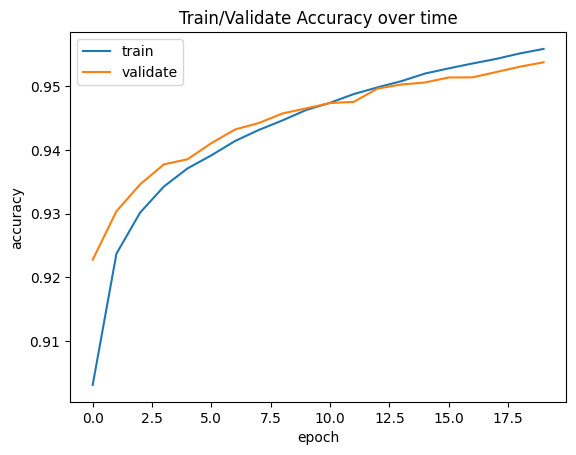

In [ ]:
show_model_accuracy(history2)

There is not much over-fitting here.

In [ ]:
save_submission(model2, 'submission2_rs_cnn.csv')


57458/57458 ━━━━━━━━━━━━━━━━━━━━ 259s 4ms/step


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

**Define method for creating model with some parameters**

In [ ]:
from tensorflow.keras import layers, models, optimizers

def create_cnn_model(input_shape=(96, 96, 3),lr=0.001,drop_rate=0.50,normalization=False):
    # use Sequential to start empty CNN
    model = Sequential()

    # add convolutional layers
    model.add(layers.Conv2D(filters=16, kernel_size=(3, 3), activation='relu'))
    if normalization:
      model.add(layers.BatchNormalization())

    model.add(layers.Conv2D(filters=16, kernel_size=(3, 3), activation='relu'))
    if normalization:
      model.add(layers.BatchNormalization())

    model.add(layers.MaxPool2D(pool_size=(2, 2)))
    model.add(layers.Conv2D(filters=32, kernel_size=(3, 3), activation='relu'))
    if normalization:
      model.add(layers.BatchNormalization())
    model.add(layers.Conv2D(filters=32, kernel_size=(3, 3), activation='relu'))
    if normalization:
      model.add(layers.BatchNormalization())
    model.add(layers.MaxPool2D(pool_size=(2, 2)))

    # add dense layers
    model.add(layers.Flatten())
    model.add(layers.Dense(units=256, activation='relu'))

    # add dropout layer to reduce overfitting
    model.add(layers.Dropout(drop_rate))

    # use sigmoid since output is binary
    model.add(layers.Dense(units=1, activation='sigmoid'))

    # use Adam as optimzer (recommended in the course)
    opt = optimizers.Adam(learning_rate=lr)

    # compile
    #model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy', tf.keras.metrics.AUC()])
    model.compile(optimizer=opt, loss='binary_crossentropy', metrics=[tf.keras.metrics.AUC(name='auc'), tf.keras.metrics.BinaryAccuracy()])


    # build
    #model.build(input_shape=(256, 64, 64, 3))

    return model

In [ ]:
from tensorflow.keras import regularizers

def create_cnn_model_2(input_shape=(96, 96, 3),lr=0.001,drop_rate=0.50,normalization=False):
    # use Sequential to start empty CNN
    model = Sequential()

    # add convolutional layers
    model.add(layers.Conv2D(filters=16, kernel_size=(3, 3), activation='relu', kernel_regularizer=regularizers.l2(0.001)))
    if normalization:
      model.add(layers.BatchNormalization())

    model.add(layers.Conv2D(filters=16, kernel_size=(3, 3), activation='relu', kernel_regularizer=regularizers.l2(0.001)))
    if normalization:
      model.add(layers.BatchNormalization())

    model.add(layers.MaxPool2D(pool_size=(2, 2)))
    model.add(layers.Conv2D(filters=32, kernel_size=(3, 3), activation='relu', kernel_regularizer=regularizers.l2(0.001)))
    if normalization:
      model.add(layers.BatchNormalization())
    model.add(layers.Conv2D(filters=32, kernel_size=(3, 3), activation='relu', kernel_regularizer=regularizers.l2(0.001)))
    if normalization:
      model.add(layers.BatchNormalization())
    model.add(layers.MaxPool2D(pool_size=(2, 2)))

    # add dense layers
    model.add(layers.Flatten())
    model.add(layers.Dense(units=256, activation='relu', kernel_regularizer=regularizers.l2(0.001)))

    # add dropout layer to reduce overfitting
    model.add(layers.Dropout(drop_rate))

    # use sigmoid since output is binary
    model.add(layers.Dense(units=1, activation='sigmoid'))

    # use Adam as optimzer (recommended in the course)
    opt = optimizers.Adam(learning_rate=lr)

    # compile
    #model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy', tf.keras.metrics.AUC()])
    model.compile(optimizer=opt, loss='binary_crossentropy', metrics=[tf.keras.metrics.AUC(name='auc'), tf.keras.metrics.BinaryAccuracy()])


    # build
    #model.build(input_shape=(256, 64, 64, 3))

    return model

**Model 3**

Create CNN model with default parameters defined in method like lr=0.001, drop_rate=0.50, normalization=False

In [ ]:

model3 = create_cnn_model()
history3 = model3.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=20,
    callbacks = [callback]
)

Epoch 1/20
5501/5501 ━━━━━━━━━━━━━━━━━━━━ 145s 25ms/step - auc: 0.8542 - binary_accuracy: 0.7869 - loss: 0.4628 - val_auc: 0.9113 - val_binary_accuracy: 0.8412 - val_loss: 0.3752
Epoch 2/20
5501/5501 ━━━━━━━━━━━━━━━━━━━━ 134s 24ms/step - auc: 0.9273 - binary_accuracy: 0.8585 - loss: 0.3358 - val_auc: 0.9499 - val_binary_accuracy: 0.8831 - val_loss: 0.2824
Epoch 3/20
5501/5501 ━━━━━━━━━━━━━━━━━━━━ 141s 26ms/step - auc: 0.9475 - binary_accuracy: 0.8827 - loss: 0.2858 - val_auc: 0.9519 - val_binary_accuracy: 0.8678 - val_loss: 0.3101
Epoch 4/20
5501/5501 ━━━━━━━━━━━━━━━━━━━━ 138s 25ms/step - auc: 0.9565 - binary_accuracy: 0.8955 - loss: 0.2592 - val_auc: 0.9558 - val_binary_accuracy: 0.8949 - val_loss: 0.2654
Epoch 5/20
5501/5501 ━━━━━━━━━━━━━━━━━━━━ 135s 24ms/step - auc: 0.9637 - binary_accuracy: 0.9042 - loss: 0.2363 - val_auc: 0.9597 - val_binary_accuracy: 0.8900 - val_loss: 0.2647
Epoch 6/20
5501/5501 ━━━━━━━━━━━━━━━━━━━━ 139s 25ms/step - auc: 0.9691 - binary_accuracy: 0.9119 - loss: 

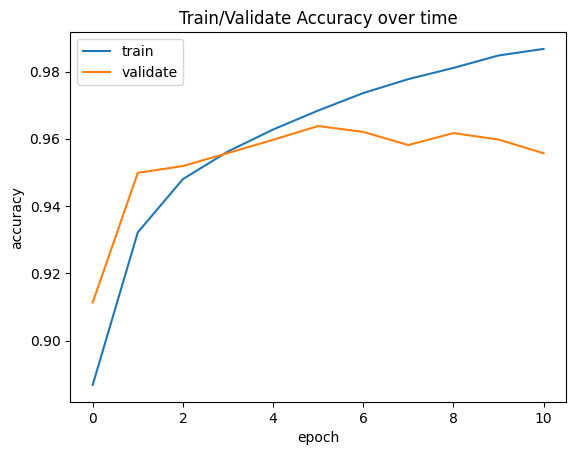

In [ ]:
show_model_accuracy(history3)

In [ ]:

save_submission(model3, 'submission3_rs_cnn.csv')

57458/57458 ━━━━━━━━━━━━━━━━━━━━ 104s 2ms/step


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

**Model 4**

Create CNN model with parameters lr=0.001, drop_rate=0.50, **normalization=True**

In [ ]:

model4 = create_cnn_model(normalization=True)
history4 = model4.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=20,
    callbacks = [callback]
)


Epoch 1/20
5501/5501 ━━━━━━━━━━━━━━━━━━━━ 149s 26ms/step - auc: 0.8583 - binary_accuracy: 0.8011 - loss: 0.5938 - val_auc: 0.8367 - val_binary_accuracy: 0.6570 - val_loss: 0.7471
Epoch 2/20
5501/5501 ━━━━━━━━━━━━━━━━━━━━ 138s 25ms/step - auc: 0.9290 - binary_accuracy: 0.8636 - loss: 0.3385 - val_auc: 0.9422 - val_binary_accuracy: 0.8842 - val_loss: 0.2975
Epoch 3/20
5501/5501 ━━━━━━━━━━━━━━━━━━━━ 138s 25ms/step - auc: 0.9490 - binary_accuracy: 0.8864 - loss: 0.2856 - val_auc: 0.9407 - val_binary_accuracy: 0.8075 - val_loss: 0.6713
Epoch 4/20
5501/5501 ━━━━━━━━━━━━━━━━━━━━ 140s 25ms/step - auc: 0.9596 - binary_accuracy: 0.9005 - loss: 0.2531 - val_auc: 0.9382 - val_binary_accuracy: 0.8174 - val_loss: 0.4474
Epoch 5/20
5501/5501 ━━━━━━━━━━━━━━━━━━━━ 137s 25ms/step - auc: 0.9662 - binary_accuracy: 0.9091 - loss: 0.2306 - val_auc: 0.9689 - val_binary_accuracy: 0.9142 - val_loss: 0.2218
Epoch 6/20
5501/5501 ━━━━━━━━━━━━━━━━━━━━ 136s 25ms/step - auc: 0.9703 - binary_accuracy: 0.9165 - loss: 

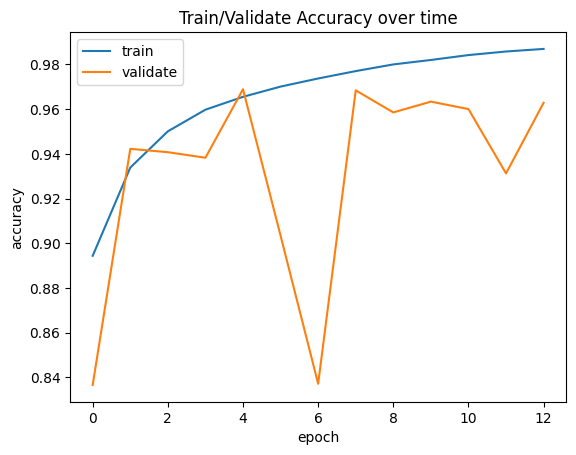

In [ ]:
show_model_accuracy(history4)

In [ ]:
save_submission(model4, 'submission4_rs_cnn.csv')


57458/57458 ━━━━━━━━━━━━━━━━━━━━ 103s 2ms/step


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

**Model 5**

Create CNN model with parameters lr=0.001, **drop_rate=0.30**, normalization=True

In [ ]:

model5 = create_cnn_model(drop_rate=0.30, normalization=True)
history5 = model5.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=20,
    callbacks = [callback]
)

Epoch 1/20
5501/5501 ━━━━━━━━━━━━━━━━━━━━ 149s 26ms/step - auc: 0.8697 - binary_accuracy: 0.8104 - loss: 0.5506 - val_auc: 0.7775 - val_binary_accuracy: 0.7020 - val_loss: 0.6556
Epoch 2/20
5501/5501 ━━━━━━━━━━━━━━━━━━━━ 140s 26ms/step - auc: 0.9415 - binary_accuracy: 0.8791 - loss: 0.3051 - val_auc: 0.9558 - val_binary_accuracy: 0.8834 - val_loss: 0.2756
Epoch 3/20
5501/5501 ━━━━━━━━━━━━━━━━━━━━ 142s 26ms/step - auc: 0.9560 - binary_accuracy: 0.8980 - loss: 0.2632 - val_auc: 0.7182 - val_binary_accuracy: 0.7391 - val_loss: 6.0147
Epoch 4/20
5501/5501 ━━━━━━━━━━━━━━━━━━━━ 147s 27ms/step - auc: 0.9652 - binary_accuracy: 0.9098 - loss: 0.2328 - val_auc: 0.9115 - val_binary_accuracy: 0.8322 - val_loss: 0.3802
Epoch 5/20
5501/5501 ━━━━━━━━━━━━━━━━━━━━ 143s 26ms/step - auc: 0.9719 - binary_accuracy: 0.9210 - loss: 0.2080 - val_auc: 0.9456 - val_binary_accuracy: 0.8797 - val_loss: 0.3063
Epoch 6/20
5501/5501 ━━━━━━━━━━━━━━━━━━━━ 141s 26ms/step - auc: 0.9774 - binary_accuracy: 0.9296 - loss: 

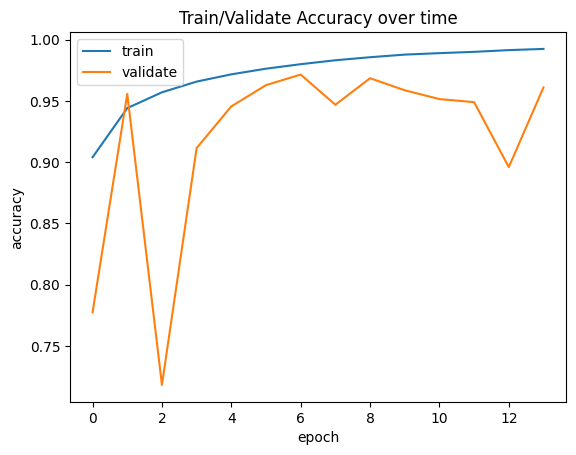

In [ ]:
show_model_accuracy(history5)

In [ ]:

save_submission(model5, 'submission5_rs_cnn.csv')

57458/57458 ━━━━━━━━━━━━━━━━━━━━ 106s 2ms/step


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

**Model 6**

Create CNN model with parameters **lr=0.0001**, drop_rate=0.50, normalization=True

In [ ]:

model6 = create_cnn_model(lr=0.0001, normalization=True)
history6 = model6.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=20,
    callbacks = [callback]
)

Epoch 1/20
5501/5501 ━━━━━━━━━━━━━━━━━━━━ 151s 26ms/step - auc: 0.8603 - binary_accuracy: 0.7961 - loss: 0.4710 - val_auc: 0.9264 - val_binary_accuracy: 0.8398 - val_loss: 0.3797
Epoch 2/20
5501/5501 ━━━━━━━━━━━━━━━━━━━━ 141s 26ms/step - auc: 0.9186 - binary_accuracy: 0.8501 - loss: 0.3564 - val_auc: 0.9412 - val_binary_accuracy: 0.8693 - val_loss: 0.3059
Epoch 3/20
5501/5501 ━━━━━━━━━━━━━━━━━━━━ 141s 26ms/step - auc: 0.9346 - binary_accuracy: 0.8655 - loss: 0.3202 - val_auc: 0.9486 - val_binary_accuracy: 0.8804 - val_loss: 0.2853
Epoch 4/20
5501/5501 ━━━━━━━━━━━━━━━━━━━━ 141s 26ms/step - auc: 0.9471 - binary_accuracy: 0.8798 - loss: 0.2885 - val_auc: 0.9556 - val_binary_accuracy: 0.8915 - val_loss: 0.2640
Epoch 5/20
5501/5501 ━━━━━━━━━━━━━━━━━━━━ 142s 26ms/step - auc: 0.9564 - binary_accuracy: 0.8931 - loss: 0.2614 - val_auc: 0.9594 - val_binary_accuracy: 0.8948 - val_loss: 0.2577
Epoch 6/20
5501/5501 ━━━━━━━━━━━━━━━━━━━━ 138s 25ms/step - auc: 0.9652 - binary_accuracy: 0.9051 - loss: 

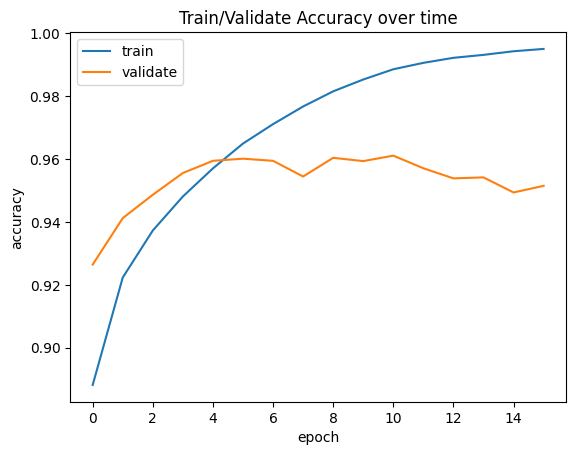

In [ ]:
show_model_accuracy(history6)

In [ ]:
save_submission(model6, 'submission6_rs_cnn.csv')


57458/57458 ━━━━━━━━━━━━━━━━━━━━ 105s 2ms/step


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

**Model 7**

Create CNN model with parameters lr=0.001, drop_rate=0.50, normalization=True.
**Added regularization to this method**

In [ ]:

model7 = create_cnn_model_2(normalization=True)
history7 = model7.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=20,
    callbacks = [callback]
)

Epoch 1/20
5501/5501 ━━━━━━━━━━━━━━━━━━━━ 155s 27ms/step - auc: 0.8552 - binary_accuracy: 0.7930 - loss: 0.8903 - val_auc: 0.8811 - val_binary_accuracy: 0.7934 - val_loss: 0.7100
Epoch 2/20
5501/5501 ━━━━━━━━━━━━━━━━━━━━ 141s 26ms/step - auc: 0.9324 - binary_accuracy: 0.8677 - loss: 0.5016 - val_auc: 0.9144 - val_binary_accuracy: 0.8434 - val_loss: 0.5024
Epoch 3/20
5501/5501 ━━━━━━━━━━━━━━━━━━━━ 140s 26ms/step - auc: 0.9453 - binary_accuracy: 0.8861 - loss: 0.4336 - val_auc: 0.8532 - val_binary_accuracy: 0.7177 - val_loss: 0.8052
Epoch 4/20
5501/5501 ━━━━━━━━━━━━━━━━━━━━ 140s 26ms/step - auc: 0.9485 - binary_accuracy: 0.8892 - loss: 0.4105 - val_auc: 0.9401 - val_binary_accuracy: 0.8702 - val_loss: 0.4321
Epoch 5/20
5501/5501 ━━━━━━━━━━━━━━━━━━━━ 143s 26ms/step - auc: 0.9521 - binary_accuracy: 0.8928 - loss: 0.3974 - val_auc: 0.9583 - val_binary_accuracy: 0.8963 - val_loss: 0.3829
Epoch 6/20
5501/5501 ━━━━━━━━━━━━━━━━━━━━ 146s 26ms/step - auc: 0.9533 - binary_accuracy: 0.8942 - loss: 

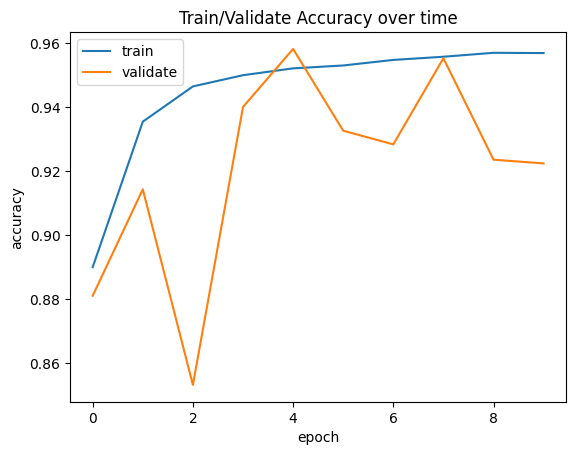

In [ ]:
show_model_accuracy(history7)

In [ ]:

save_submission(model7, 'submission7_rs_cnn.csv')

57458/57458 ━━━━━━━━━━━━━━━━━━━━ 105s 2ms/step


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

**Model 8**

In [ ]:

callback8 = tf.keras.callbacks.EarlyStopping(monitor='val_auc', patience=5, restore_best_weights=True)
model8 = create_cnn_model_2(normalization=True)
history8 = model8.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=20,
    callbacks = [callback8]
)


Epoch 1/20
5501/5501 ━━━━━━━━━━━━━━━━━━━━ 152s 26ms/step - auc: 0.8583 - binary_accuracy: 0.8003 - loss: 0.9785 - val_auc: 0.8349 - val_binary_accuracy: 0.7471 - val_loss: 0.8696
Epoch 2/20
5501/5501 ━━━━━━━━━━━━━━━━━━━━ 139s 25ms/step - auc: 0.9326 - binary_accuracy: 0.8685 - loss: 0.5059 - val_auc: 0.9501 - val_binary_accuracy: 0.8794 - val_loss: 0.4380
Epoch 3/20
5501/5501 ━━━━━━━━━━━━━━━━━━━━ 139s 25ms/step - auc: 0.9477 - binary_accuracy: 0.8878 - loss: 0.4311 - val_auc: 0.9446 - val_binary_accuracy: 0.7759 - val_loss: 0.6799
Epoch 4/20
5501/5501 ━━━━━━━━━━━━━━━━━━━━ 139s 25ms/step - auc: 0.9533 - binary_accuracy: 0.8941 - loss: 0.3927 - val_auc: 0.8187 - val_binary_accuracy: 0.7688 - val_loss: 0.9403
Epoch 5/20
5501/5501 ━━━━━━━━━━━━━━━━━━━━ 142s 26ms/step - auc: 0.9557 - binary_accuracy: 0.8968 - loss: 0.3699 - val_auc: 0.9166 - val_binary_accuracy: 0.8492 - val_loss: 0.4582
Epoch 6/20
5501/5501 ━━━━━━━━━━━━━━━━━━━━ 140s 26ms/step - auc: 0.9564 - binary_accuracy: 0.8995 - loss: 

In [ ]:
save_submission(model8, 'submission8_rs_cnn.csv')

57458/57458 ━━━━━━━━━━━━━━━━━━━━ 106s 2ms/step


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
add_to_results('Model 1 - Base CNN Model', history1, 0.8252, 0.8605)

add_to_results('Model 2 - Pre-trained Model', history2, 0.7821, 0.8114)

add_to_results('Model 3 - Modified CNN Model', history3, 0.8176, 0.8201)

add_to_results('Model 4 - CNN Model - Normalized', history4, 0.8298, 0.8694)

add_to_results('Model 5 - Drop Rate Changed', history5, 0.8098, 0.8699)

add_to_results('Model 6 - Learning Rate Reduced', history6, 0.7872, 0.8386)

add_to_results('Model 7 - Added Regularization', history7, 0.8030, 0.8055)

add_to_results('Model 8 - Changed Early Stopping', history8, 0.7720, 0.8022)


<ipython-input-31-48d4c2962b6b>:17: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_results = pd.concat([df_results, new_rows_df], ignore_index=True)


# Analysis


We experimented with several modifications to the model architecture, including adjusting the number and type of layers, and performed hyperparameter tuning—such as varying the number of epochs, implementing early stopping, and tweaking the learning rate and dropout rate. These changes helped improve the performance of one of the models. However, not all adjustments led to better results. After implementing Model #4, we reached a performance max and were unable to achieve further improvement in the evaluation score.

In [ ]:
print(df_results)

                         Model Name  Kaggle Private Score  Kaggle Public Score
0          Model 1 - Base CNN Model                0.8252               0.8605
1       Model 2 - Pre-trained Model                0.7821               0.8114
2      Model 3 - Modified CNN Model                0.8176               0.8201
3  Model 4 - CNN Model - Normalized                0.8298               0.8694
4       Model 5 - Drop Rate Changed                0.8098               0.8699
5   Model 6 - Learning Rate Reduced                0.7872               0.8386
6    Model 7 - Added Regularization                0.8030               0.8055
7  Model 8 - Changed Early Stopping                0.7720               0.8022


**Best Model**
We submitted multiple models to Kaggle to evaluate them using both public and private AUC scores. While **Model #5** achieved the highest public score (0.8699), **Model #4** showed the best overall performance:

| Model    | Public AUC | Private AUC | Notes                          |
| -------- | ---------- | ----------- | ------------------------------ |
| Model #4 | 0.8694     | **0.8298**  | Best combined performance    |
| Model #5 | **0.8699** | 0.8098      | High public, lower private AUC |
| Others   | —          | —           | Lower performance overall      |

Most model trials had quite similar results.Given its high and balanced scores on both public and private leaderboards, **Model #4** was selected as the final model. This suggests it generalizes better across unseen data and is less prone to overfitting to the public test subset. This was the model where we added **BatchNormalization**.

In [ ]:
model4.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_7 (Conv2D)               │ (None, 94, 94, 16)     │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 94, 94, 16)     │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 92, 92, 16)     │         2,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 92, 92, 16)     │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 46, 46, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 44, 44, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 44, 44, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 42, 42, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 42, 42, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 21, 21, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 14112)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 256)            │     3,612,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 10,890,293 (41.54 MB)

 Trainable params: 3,630,033 (13.85 MB)

 Non-trainable params: 192 (768.00 B)

 Optimizer params: 7,260,068 (27.69 MB)

In [ ]:
model1.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 94, 94, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 47, 47, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 45, 45, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 22, 22, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 20, 20, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 10, 10, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 12800)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │     6,554,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           513 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 19,943,621 (76.08 MB)

 Trainable params: 6,647,873 (25.36 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 13,295,748 (50.72 MB)

In [ ]:
model2.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)              │ (None, 3, 3, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1024)           │       525,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │         1,025 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 16,293,701 (62.16 MB)

 Trainable params: 526,337 (2.01 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

 Optimizer params: 1,052,676 (4.02 MB)

In [ ]:
model3.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)               │ (None, 94, 94, 16)     │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 92, 92, 16)     │         2,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 46, 46, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 44, 44, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 42, 42, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 21, 21, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 14112)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 256)            │     3,612,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 10,889,525 (41.54 MB)

 Trainable params: 3,629,841 (13.85 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 7,259,684 (27.69 MB)

In [ ]:
model5.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_11 (Conv2D)              │ (None, 94, 94, 16)     │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 94, 94, 16)     │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_12 (Conv2D)              │ (None, 92, 92, 16)     │         2,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 92, 92, 16)     │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 46, 46, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_13 (Conv2D)              │ (None, 44, 44, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 44, 44, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_14 (Conv2D)              │ (None, 42, 42, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 42, 42, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 21, 21, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 14112)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 256)            │     3,612,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 10,890,293 (41.54 MB)

 Trainable params: 3,630,033 (13.85 MB)

 Non-trainable params: 192 (768.00 B)

 Optimizer params: 7,260,068 (27.69 MB)

In [ ]:
model6.summary()

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_15 (Conv2D)              │ (None, 94, 94, 16)     │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 94, 94, 16)     │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_16 (Conv2D)              │ (None, 92, 92, 16)     │         2,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_9           │ (None, 92, 92, 16)     │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ (None, 46, 46, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_17 (Conv2D)              │ (None, 44, 44, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_10          │ (None, 44, 44, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_18 (Conv2D)              │ (None, 42, 42, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_11          │ (None, 42, 42, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_10 (MaxPooling2D) │ (None, 21, 21, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_4 (Flatten)             │ (None, 14112)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 256)            │     3,612,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 10,890,293 (41.54 MB)

 Trainable params: 3,630,033 (13.85 MB)

 Non-trainable params: 192 (768.00 B)

 Optimizer params: 7,260,068 (27.69 MB)

In [ ]:
model7.summary()

Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_19 (Conv2D)              │ (None, 94, 94, 16)     │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_12          │ (None, 94, 94, 16)     │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_20 (Conv2D)              │ (None, 92, 92, 16)     │         2,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_13          │ (None, 92, 92, 16)     │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_11 (MaxPooling2D) │ (None, 46, 46, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_21 (Conv2D)              │ (None, 44, 44, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_14          │ (None, 44, 44, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_22 (Conv2D)              │ (None, 42, 42, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_15          │ (None, 42, 42, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_12 (MaxPooling2D) │ (None, 21, 21, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_5 (Flatten)             │ (None, 14112)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 256)            │     3,612,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 10,890,293 (41.54 MB)

 Trainable params: 3,630,033 (13.85 MB)

 Non-trainable params: 192 (768.00 B)

 Optimizer params: 7,260,068 (27.69 MB)

In [ ]:
model8.summary()

Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_23 (Conv2D)              │ (None, 94, 94, 16)     │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_16          │ (None, 94, 94, 16)     │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_24 (Conv2D)              │ (None, 92, 92, 16)     │         2,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_17          │ (None, 92, 92, 16)     │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_13 (MaxPooling2D) │ (None, 46, 46, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_25 (Conv2D)              │ (None, 44, 44, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_18          │ (None, 44, 44, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_26 (Conv2D)              │ (None, 42, 42, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_19          │ (None, 42, 42, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_14 (MaxPooling2D) │ (None, 21, 21, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_6 (Flatten)             │ (None, 14112)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 256)            │     3,612,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 10,890,293 (41.54 MB)

 Trainable params: 3,630,033 (13.85 MB)

 Non-trainable params: 192 (768.00 B)

 Optimizer params: 7,260,068 (27.69 MB)

# Conclusion

This project gave me valuable experience with building CNN models for medical image detection tasks. I gained a deeper understanding of how different layers and hyperparameters impact model performance. For this particular dataset, adding Batch Normalization significantly improved the results, while adjusting the learning rate had limited effect.

In the future, I'd like to experiment with varying the number of neurons and incorporating data augmentation to improve model generalization. Additionally, instead of manually tuning parameters, I plan to use grid search for a more systematic approach to hyperparameter optimization.

Overall, the selected model delivered promising results and demonstrated solid performance on the task.
